In [1]:
import json
import os
from collections import defaultdict
from datetime import datetime, timedelta
from glob import glob
from math import asin, cos, radians, sin, sqrt
from numbers import Real
from typing import Any, Iterator, Tuple, Union
from sshtunnel import SSHTunnelForwarder

import paramiko
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
import sshtunnel
import MySQLdb

from numpy import positive
from pyproj import Transformer, transform
from shapely.geometry import Point, Polygon
from sqlalchemy import (
    Connection,
    CursorResult,
    Engine,
    Select,
    TextClause,
    create_engine,
    func,
    select,
)
from sqlalchemy.sql.expression import text

In [2]:
timelike = Union[str, Real, datetime, pd.Timestamp]

def to_datetime(time: timelike) -> pd.Timestamp:
    if isinstance(time, str):
        time = pd.Timestamp(time, tz="utc")
    elif isinstance(time, datetime):
        time = pd.to_datetime(time, utc=True)
    elif isinstance(time, Real):
        time = pd.Timestamp(float(time), unit="s", tz="utc")
    return time

In [3]:
LAT_MIN, LAT_MAX = 50.896393, 50.967115
LON_MIN, LON_MAX = 6.919968, 7.005756
ALT_MIN, ALT_MAX = 0, 750 # update from 700 m to 750 m, in line with CTR limit at 2500 ft plus margin (and accounting for Geoid Height)

TIME_BETWEEN_TRAJS = 30

# SERA.5005(f)(1) criteria
ALERT_DISTANCE_M = 600      # alert distance wrt obstacles (should be 600)
ALERT_DELTA_HEIGHT_M = 300   # delta height (should be 300)

CPA_MARGIN_M = 20 # allowance for lateral distance to obstacle
DIP_MARGIN_M = 20 # allowance for dip below minimum height (45m corresponds to GVA = 2)
N_MIN = 5

GEOID_HEIGHT_M = 47  # geoid height for Cologne

sshtunnel.SSH_TIMEOUT = 15.0
sshtunnel.TUNNEL_TIMEOUT = 15.0

# Setup OpenSky Network Trino credentials

In [4]:
OSN_secrets_json = './trino_secrets.json'
MYSQL_secrets_json = './mysql_secrets.json'

with open(OSN_secrets_json) as OSN_secrets:
  OSN_creds = json.load(OSN_secrets)

with open(MYSQL_secrets_json) as MYSQL_secrets:
  MYSQL_creds = json.load(MYSQL_secrets)

os.environ['OPENSKY_USERNAME'] = OSN_creds['OPENSKY_USERNAME']
os.environ['OPENSKY_PASSWORD'] = OSN_creds['OPENSKY_PASSWORD']

# Test connection with basic SQL query

In [5]:
from pyopensky.trino import Trino

trino = Trino()

query = "select * from state_vectors_data4 limit 5"

df = trino.query(query, cached = False)

FINISHED: : 24.6% [00:00, 211%/s]
DOWNLOAD: 5.00lines [00:00, 100lines/s]


# Send queries and merge results

In [6]:
start_str = "01/09/24"
end_str = "07/09/24"

start = datetime.strptime(start_str, '%d/%m/%y')
end = datetime.strptime(end_str, '%d/%m/%y')

# Modify start_date to be 00:00:00
start = start.replace(hour=0, minute=0, second=1, microsecond=0)
# Modify end_date to be 23:59:59
end = end.replace(hour=23, minute=59, second=59, microsecond=999999)

start_time = int(start.timestamp())
start_hour = start_time - (start_time % 3600)
end_time = int(end.timestamp())
end_hour = end_time - (end_time % 3600)

In [7]:
svdata4_query = (
        f"SELECT * FROM state_vectors_data4"
        f" WHERE icao24 LIKE '%'"
        f" AND time >= {start_time} AND time <= {end_time}"
        f" AND hour >= {start_hour} AND hour <= {end_hour}"
        f" AND lat >= {LAT_MIN} AND lat <= {LAT_MAX}"
        f" AND lon>= {LON_MIN} AND lon <= {LON_MAX}"
        f" AND geoaltitude >= {ALT_MIN} AND geoaltitude <= {ALT_MAX}"
        f" ORDER BY time"
    )

trino = Trino()

svdata4_df = trino.query(
    svdata4_query,
    cached=False,
    compress=True,
)

FINISHED: : 100% [00:00, 142%/s]
DOWNLOAD: 8.04klines [00:00, 59.0klines/s]


In [8]:
icao_list = svdata4_df.icao24.unique()
icao24_str = ', '.join(f"'{item}'" for item in icao_list)

ops_sts_query = (
    f"SELECT icao24, mintime, maxtime, nacv, systemdesignassurance, version, positionnac, geometricverticalaccuracy, sourceintegritylevel, barometricaltitudeintegritycode  FROM operational_status_data4"
    f" WHERE icao24 IN ({icao24_str})"
    f" AND mintime >= {start_time} AND maxtime <= {end_time}"
    f" AND hour >= {start_hour} AND hour <= {end_hour}"
    f" ORDER by mintime"
)

print('Connecting to OSN database...')
trino = Trino()
ops_sts_df = trino.query(
    ops_sts_query,
    cached=False,
)

ops_sts_df['time'] = ops_sts_df['mintime'].astype('int64')

Connecting to OSN database...


FINISHING: : 100% [00:02, 42.0%/s]
DOWNLOAD: 543klines [00:24, 21.9klines/s]


In [9]:
# Initialize an empty DataFrame to hold the results
merged_df = pd.DataFrame()

# Loop over each unique 'icao24' in both dataframes
unique_icao24s = pd.concat([svdata4_df['icao24'], ops_sts_df['icao24']]).unique()

for icao24 in unique_icao24s:
    # Filter each dataframe by 'icao24'
    sub_df1 = svdata4_df[svdata4_df['icao24'] == icao24]
    sub_df2 = ops_sts_df[ops_sts_df['icao24'] == icao24]

    # Ensure both sub-dataframes are sorted by 'time'
    sub_df1 = sub_df1.sort_values('time')
    sub_df2 = sub_df2.sort_values('time')

    # Perform merge_asof on the filtered and sorted dataframes
    merged_sub_df = pd.merge_asof(sub_df1, sub_df2, on='time', by='icao24', direction='backward')
    
    # Append the result to the main dataframe
    merged_df = pd.concat([merged_df, merged_sub_df], ignore_index=True)


In [10]:
posdata4_query = (
    f"SELECT mintime, icao24, nic  FROM position_data4"
    f" WHERE icao24 IN ({icao24_str})"
    f" AND lat >= {LAT_MIN} AND lat <= {LAT_MAX}"
    f" AND lon>= {LON_MIN} AND lon <= {LON_MAX}"
    f" AND mintime >= {start_time} AND maxtime <= {end_time}"
    f" AND hour >= {start_hour} AND hour <= {end_hour}"
    f" ORDER by mintime"
)

print('Connecting to OSN database...')
trino = Trino()
posdata4_df = trino.query(
    posdata4_query,
    cached=False,
)

posdata4_df['time'] = posdata4_df['mintime'].astype('int64')

Connecting to OSN database...


FINISHED: : 100% [00:00, 434%/s]
DOWNLOAD: 23.2klines [00:00, 263klines/s]


In [11]:
# Initialize an empty DataFrame to hold the results
final_df = pd.DataFrame()

for icao24 in unique_icao24s:
    # Filter each dataframe by 'icao24'
    sub_df1 = merged_df[merged_df['icao24'] == icao24]
    sub_df2 = posdata4_df[posdata4_df['icao24'] == icao24]

    # Ensure both sub-dataframes are sorted by 'time'
    sub_df1 = sub_df1.sort_values('time')
    sub_df2 = sub_df2.sort_values('time')

    # Perform merge_asof on the filtered and sorted dataframes
    merged_sub_df = pd.merge_asof(sub_df1, sub_df2, on='time', by='icao24', direction='backward')
    
    # Append the result to the main dataframe
    final_df = pd.concat([final_df, merged_sub_df], ignore_index=True)

final_df = final_df.drop(columns=['hour', 'mintime_x', 'maxtime', 'mintime_y'])


# Add DEM ground elevation information

In [15]:
crs_transformer = Transformer.from_crs(4326, 25832, always_xy = True) # Transformer from WGS-84 to ETRS89-LAEA 3035

def transform_coords(lon, lat):
    return crs_transformer.transform(lon, lat)

In [16]:
final_df['gnd_elev'] = np.nan

dem_src = rasterio.open('./resources/Cologne_DEM_merged_from_LAS_25x25.tif')

final_df['etrs89_x'], final_df['etrs89_y'] = zip(*final_df.apply(lambda row: transform_coords(row['lon'], row['lat']), axis=1))


In [17]:
def get_elevation(x, y, dem):
    row, col = dem.index(x, y)
    return dem.read(1)[row, col]

final_df['gnd_elev'] = final_df.apply(lambda row: get_elevation(row['etrs89_x'], row['etrs89_y'], dem_src), axis=1)

In [19]:
final_df = final_df.drop(columns=['etrs89_x', 'etrs89_y'])

# Add population density

In [20]:
final_df['pop_density'] = np.nan

pop_src = rasterio.open('./resources/GHS_POP_E2020_GLOBE_R2023A_4326_3ss_V1_0_Cologne.tif')

def get_population(lon, lat, pop_src):
    row, col = pop_src.index(lon, lat)
    return pop_src.read(1)[row, col]

final_df['pop_density'] = final_df.apply(lambda row: get_population(row['lon'], row['lat'], pop_src), axis=1)


<AxesSubplot: >

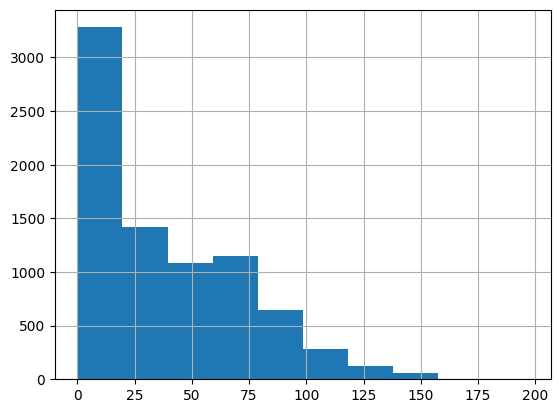

In [24]:
final_df.pop_density.hist()

# Process df with distance information

In [16]:
def haversine(pt1, pt2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    Returned units are in metres. Differs slightly from PostGIS geography
    distance, which uses a spheroid, rather than a sphere.
    """

    lat1, lon1 = pt1[0], pt1[1]
    lat2, lon2 = pt2[0], pt2[1]

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2.0) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2.0) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371000  # Radius of earth in m
    return c * r

In [17]:
final_df["prev_time"] = final_df.time.shift()
final_df['closest_obst_name'] = 'ground'
final_df['inf_flt'] = False
final_df['inf_pt'] = False
final_df['gnd_inf_flt'] = False
final_df['gnd_inf_pt'] = False
final_df['min_hgt'] = final_df['gnd_elev'] + 300 # Minimum height away from obstacles is 300 m above ground (over congested areas)

map_time_traj = defaultdict(dict)

for icao, sfinal_df in final_df.groupby("icao24"):
    map_time_traj[icao][sfinal_df.iloc[0]["time"]] = icao + "_1"
    n_traj = 1
    for i in range(1, sfinal_df.shape[0]):
        time = sfinal_df.iloc[i]["time"]
        diff = abs(int(time) - int(sfinal_df.iloc[i]["prev_time"]))
        if diff > TIME_BETWEEN_TRAJS:
            n_traj += 1
        map_time_traj[icao][time] = icao + "_" + str(int(n_traj))

final_df['ref'] = final_df.apply(lambda x: map_time_traj[x.icao24][x.time], axis=1) + '_' + final_df.time.apply(lambda x: pd.to_datetime(x, unit='s').strftime("%d%m%y"))

# Add a distance column and compute cumulative along-track distance for each flight
final_df['dist'] = 0.0
for flight in final_df.ref.unique():
  first = True
  current = final_df[final_df['ref'].isin([flight])] # gets the trajectory of the current flight
  for row in current.itertuples():
    if not(first):
      current_pt = (float(row.lat), float(row.lon))
      delta_dist = haversine(previous_pt, current_pt)
      final_df.loc[row[0],'dist'] = previous_dist + delta_dist
    previous_pt = (float(row.lat), float(row.lon))
    previous_dist = final_df.loc[row[0],'dist']
    first = False


# Load obstacle information and check min height

In [18]:
path_to_obstacles_json = './resources/obstacles.json'

with open(path_to_obstacles_json) as obstacles_database:
    obstacles_data = json.load(obstacles_database)
obs_df = pd.json_normalize(obstacles_data, record_path =['obstacles'])

obs_df['etrs89_x'], obs_df['etrs89_y'] = zip(*obs_df.apply(lambda row: transform_coords(row['lon'], row['lat']), axis=1))
obs_df['gnd_elev'] = obs_df.apply(lambda row: get_elevation(row['etrs89_x'], row['etrs89_y'], dem_src), axis=1)
obs_df = obs_df.drop(columns=['etrs89_x', 'etrs89_y'])

obs_df = obs_df.sort_values(by=['height_m']) # sort obstacles by incresing height, to avoid that the min_hgt profil is wrong if a shorter obstacle comes after a taller one, in case the aircraft is within two obstacles clearance areas


In [19]:
def update_closest_obstacle(final_df, obstacles_df, radius):
    # Iterate over each point in the final_df
    for index, row in final_df.iterrows():
        point = (row['lat'], row['lon'])
        
        # Filter obstacles within the given radius
        obstacles_within_radius = obstacles_df[
            obstacles_df.apply(lambda obs: haversine(point, (obs['lat'], obs['lon'])) <= radius, axis=1)
        ]
        
        # If there are any obstacles within the radius, find the tallest one
        if not obstacles_within_radius.empty:
            tallest_obstacle = obstacles_within_radius.loc[obstacles_within_radius['height_m'].idxmax()]
            final_df.at[index, 'closest_obst_name'] = tallest_obstacle['name']
            final_df.at[index, 'min_hgt'] = GEOID_HEIGHT_M + np.float32(tallest_obstacle['gnd_elev']) + np.float32(tallest_obstacle['height_m']) + ALERT_DELTA_HEIGHT_M

    return final_df

In [20]:
final_df = update_closest_obstacle(final_df, obs_df, 600)

final_df['dip'] = final_df['min_hgt'] - final_df['geoaltitude']

In [23]:
rhein_coords = [[6.975930879168959,50.95657408794192],
[6.972535124899244,50.95458641663587],
[6.967809452697489,50.95085449055784],
[6.964303258235203,50.94648787705209],
[6.962946874051212,50.94281719236779],
[6.96352513940893,50.93620396292537],
[6.965306071776009,50.93028081346332],
[6.969701292329919,50.91962775943225],
[6.974670336848934,50.91147192727765],
[6.979500669602354,50.90559075596518],
[6.988910832741286,50.89811010115705],
[7.001299970098163,50.89290819036373],
[7.011608685904386,50.89253183470269],
[7.013331310567981,50.89615626376607],
[7.001160198607601,50.89750937089659],
[6.991533142700823,50.90103254802452],
[6.988667339298418,50.90270433843045],
[6.983479655838492,50.90851708398598],
[6.975279465952471,50.91906362354751],
[6.970153101800916,50.93012572612207],
[6.970658769054046,50.93156686745481],
[6.968078026948048,50.93770005507804],
[6.968636570741024,50.94353672207991],
[6.972110561853963,50.94977637503464],
[6.978430041779998,50.95436079405016],
[6.984223870632302,50.9521389418798],
[6.994914076799508,50.95996315483612],
[6.997507875246713,50.96355172063916],
[6.993574311759938,50.96491142024293],
[6.975930879168959,50.95657408794192]]

rhein_polygon = Polygon(rhein_coords)

points = gpd.GeoSeries([Point(xy) for xy in zip(final_df['lon'], final_df['lat'])])

final_df['in_rhein'] = points.within(rhein_polygon)


# Add infraction information

In [24]:
# Rule for 'inf_pt'
final_df['inf_pt'] = final_df.apply(
    lambda row: True if row['dip'] > 0 and not row['in_rhein'] and row['closest_obst_name'] != 'ground' else False,
    axis=1
)

# Rule for 'gnd_inf_pt'
final_df['gnd_inf_pt'] = final_df.apply(
    lambda row: True if (row['dip'] > 0 and row['closest_obst_name'] == 'ground') or 
                ((GEOID_HEIGHT_M + row['gnd_elev'] + ALERT_DELTA_HEIGHT_M - row['geoaltitude']) > 0) else False,
    axis=1
)

# Group by 'ref' and update 'inf_flt' based on 'inf_pt'
final_df['inf_flt'] = final_df.groupby('ref')['inf_pt'].transform('any')

# Group by 'ref' and update 'gnd_inf_flt' based on 'gnd_inf_pt'
final_df['gnd_inf_flt'] = final_df.groupby('ref')['gnd_inf_pt'].transform('any')

final_df = final_df.drop(columns=['serials', 'nacv'])


KeyError: "['serials', 'nacv'] not found in axis"

# Create infraction tables

In [30]:
inf_pt_df = final_df[final_df.inf_pt].copy()

lat, lon = obs_df.loc[obs_df['name'] == 'Ringturm', ['lat', 'lon']].values[0]

inf_pt_df['dist_to_obs'] = np.nan

inf_pt_df['dist_to_obs'] = inf_pt_df.apply(
    lambda x: haversine(
            (obs_df.loc[obs_df['name'] == x['closest_obst_name'], 'lat'].iloc[0],
            obs_df.loc[obs_df['name'] == x['closest_obst_name'], 'lon'].iloc[0]),
            (x['lat'], x['lon'])
    ) if not (x['closest_obst_name'] == 'ground') else np.nan, 
    axis=1
)

inf_pt_df['time'] = pd.to_datetime(inf_pt_df['time'], unit='s')
inf_pt_df = inf_pt_df.sort_values(by=['ref', 'closest_obst_name', 'time'])

inf_pt_df['time_diff'] = inf_pt_df.groupby(['ref', 'closest_obst_name'])['time'].diff()
inf_pt_df['group'] = (inf_pt_df['time_diff'] >= pd.Timedelta(seconds=30)).cumsum()

inf_grouped = inf_pt_df.groupby(['ref', 'closest_obst_name', 'group'])

inf_min_dist = inf_grouped.apply(lambda x: x.loc[x['dist_to_obs'].idxmin()]).reset_index(drop=True)
inf_max_dip = inf_grouped['dip'].max().reset_index()

group_size = inf_grouped.size().reset_index(name='n')

inf_result = inf_min_dist[['icao24', 'callsign', 'group', 'ref', 'closest_obst_name', 'time', 'lat', 'lon', 'dist_to_obs']].copy()
inf_result = inf_result.merge(inf_max_dip, on=['ref', 'closest_obst_name', 'group'])
inf_result = inf_result.merge(group_size, on=['ref', 'closest_obst_name', 'group'])

inf_result.rename(columns={'dist_to_obs': 'cpa', 'dip': 'dip_max', 'closest_obst_name': 'obstacle_name'}, inplace=True)

inf_result['entry_count'] = inf_result.groupby('ref').cumcount()
inf_result['inf_ref'] = inf_result['ref'].astype(str) + '_' + inf_result['entry_count'].astype(str)

inf_result['url'] = inf_result.apply(lambda row: "https://globe.adsbexchange.com/?icao=%s&lat=50.928&lon=6.947&zoom=13.2&showTrace=%s&timestamp=%s" % (
    row['icao24'],
    row['time'].strftime('%Y-%m-%d'),
    str(int(row['time'].timestamp()))
), axis=1)

inf_result = inf_result.reset_index(drop=True)

inf_result = inf_result.drop(columns=['entry_count', 'group'])

In [31]:
inf_result

,icao24,callsign,ref,obstacle_name,time,lat,lon,cpa,dip_max,n,inf_ref,url
0,3d0858,HUMMELX,3d0858_1_060624,AREO Turm,2024-06-06 09:39:32,50.913254,6.969563,491.117206,20.586396,7,3d0858_1_060624_0,https://globe.adsbexchange.com/?icao=3d0858&la...
1,3d0858,HUMMELX,3d0858_1_060624,Colonia Haus,2024-06-06 09:37:42,50.961014,6.980896,74.246305,116.789579,27,3d0858_1_060624_1,https://globe.adsbexchange.com/?icao=3d0858&la...
2,3d0858,HUMMELX,3d0858_1_060624,Heizwerk Kamine Südstadt,2024-06-06 09:39:20,50.919159,6.966000,563.008159,24.328123,6,3d0858_1_060624_2,https://globe.adsbexchange.com/?icao=3d0858&la...
3,3d0858,HUMMELX,3d0858_1_060624,Koelner Dom,2024-06-06 09:38:36,50.941509,6.960983,258.382243,127.210079,19,3d0858_1_060624_3,https://globe.adsbexchange.com/?icao=3d0858&la...
4,3d0858,HUMMELX,3d0858_1_060624,Krohstr. 4 (Bayenthal),2024-06-06 09:39:42,50.908447,6.974240,187.756304,27.950338,15,3d0858_1_060624_4,https://globe.adsbexchange.com/?icao=3d0858&la...
...,...,...,...,...,...,...,...,...,...,...,...,...
147,3ff8f3,DMNVA,3ff8f3_1_070624,Koelner Dom,2024-06-07 12:02:44,50.937645,6.958466,438.668339,20.530079,5,3ff8f3_1_070624_3,https://globe.adsbexchange.com/?icao=3ff8f3&la...
148,3ff8f3,DMNVA,3ff8f3_1_070624,Koelnturm (Mediapark),2024-06-07 12:01:59,50.945838,6.946335,349.824986,44.815840,15,3ff8f3_1_070624_4,https://globe.adsbexchange.com/?icao=3ff8f3&la...
149,3ff8f3,DMNVA,3ff8f3_1_070624,Koelnturm (Mediapark),2024-06-07 12:03:13,50.945466,6.940536,306.874999,29.575840,8,3ff8f3_1_070624_5,https://globe.adsbexchange.com/?icao=3ff8f3&la...
150,3ff8f3,DMNVA,3ff8f3_1_070624,Krohstr. 4 (Bayenthal),2024-06-07 12:00:30,50.907712,6.973801,122.746463,43.190338,16,3ff8f3_1_070624_6,https://globe.adsbexchange.com/?icao=3ff8f3&la...


Ground infractions

In [33]:
gnd_inf_pt_df = final_df[final_df.gnd_inf_pt & (final_df.dip >= 0) & (final_df.closest_obst_name == 'ground')].copy()

gnd_inf_pt_df['time'] = pd.to_datetime(gnd_inf_pt_df['time'], unit='s')
gnd_inf_pt_df = gnd_inf_pt_df.sort_values(by=['ref', 'time'])

gnd_inf_pt_df['time_diff'] = gnd_inf_pt_df.groupby(['ref'])['time'].diff()
gnd_inf_pt_df['group'] = (gnd_inf_pt_df['time_diff'] >= pd.Timedelta(seconds=30)).cumsum()

gnd_inf_grouped = gnd_inf_pt_df.groupby(['ref', 'group'])

gnd_inf_max_dip = gnd_inf_grouped.apply(lambda x: x.loc[x['dip'].idxmax()]).reset_index(drop=True)

group_size = gnd_inf_grouped.size().reset_index(name='n')

gnd_inf_result = gnd_inf_max_dip[['icao24', 'callsign', 'group', 'ref', 'closest_obst_name', 'time', 'lat', 'lon', 'dip']].copy()

gnd_inf_result = gnd_inf_result.merge(group_size, on=['ref', 'group'])

gnd_inf_result.rename(columns={'dip': 'dip_max', 'closest_obst_name': 'obstacle_name'}, inplace=True)

gnd_inf_result['entry_count'] = gnd_inf_result.groupby('ref').cumcount()
gnd_inf_result['inf_ref'] = gnd_inf_result['ref'].astype(str) + '_' + 'gnd_' + gnd_inf_result['entry_count'].astype(str)

gnd_inf_result['url'] = gnd_inf_result.apply(lambda row: "https://globe.adsbexchange.com/?icao=%s&lat=50.928&lon=6.947&zoom=13.2&showTrace=%s&timestamp=%s" % (
    row['icao24'],
    row['time'].strftime('%Y-%m-%d'),
    str(int(row['time'].timestamp()))
), axis=1)

gnd_inf_result = gnd_inf_result.reset_index(drop=True)

gnd_inf_result = gnd_inf_result.drop(columns=['entry_count', 'group'])



In [36]:
inf_result.columns

Index(['icao24', 'callsign', 'ref', 'obstacle_name', 'time', 'lat', 'lon',
       'cpa', 'dip_max', 'n', 'inf_ref', 'url'],
      dtype='object')

In [35]:
gnd_inf_result.columns

Index(['icao24', 'callsign', 'ref', 'obstacle_name', 'time', 'lat', 'lon',
       'dip_max', 'n', 'inf_ref', 'url'],
      dtype='object')

# Upload data to MySQL server

In [37]:
ed25519_key = paramiko.Ed25519Key(filename='/home/dimitri/.ssh/id_ed25519')

# Set up the SSH tunnel with the RSA key
with SSHTunnelForwarder(
    (MYSQL_creds['SSH_ADDRESS'], 22),
    ssh_username=MYSQL_creds['SSH_USERNAME'],
    ssh_pkey=ed25519_key,  # Use the loaded RSA key
    remote_bind_address=(MYSQL_creds['REMOTE_BIND_ADDRESS'], MYSQL_creds['REMOTE_BIND_PORT']),
    allow_agent=False,
) as tunnel:
    
    print('connected')

    engstr =  'mysql+pymysql://' + MYSQL_creds['SSH_USERNAME'] + ':' + MYSQL_creds['PYANYWHERE_PASSWORD'] + '@127.0.0.1:' + str(tunnel.local_bind_port)+'/dme3$' + MYSQL_creds['TEST_DATABASE_NAME']

    engine = create_engine(engstr)

    print('step 1')
    
    final_df.to_sql(con=engine, name = MYSQL_creds['MAIN_TEST_TABLE_NAME'], if_exists='append')
    inf_result.to_sql(con=engine, name = MYSQL_creds['INF_TEST_TABLE_NAME'], if_exists='append')
    gnd_inf_result.to_sql(con=engine, name = MYSQL_creds['INF_TEST_TABLE_NAME'], if_exists='append')

    print("Done")

connected
step 1
Done


# Load Distant data for tests

In [221]:
with sshtunnel.SSHTunnelForwarder(
    (MYSQL_creds['SSH_ADDRESS']),
    ssh_username = MYSQL_creds['SSH_USERNAME'], ssh_password = MYSQL_creds['SSH_PASSWORD'],
    remote_bind_address = (MYSQL_creds['REMOTE_BIND_ADDRESS'], MYSQL_creds['REMOTE_BIND_PORT'])
) as tunnel:
    print('connected')

    engstr =  'mysql+pymysql://' + MYSQL_creds['SSH_USERNAME'] + ':' + MYSQL_creds['PYANYWHERE_PASSWORD'] + '@127.0.0.1:' + str(tunnel.local_bind_port)+'/dme3$' + MYSQL_creds['TEST_DATABASE_NAME']

    engine = create_engine(engstr)

    sql_query = """
    SELECT ref, lat, lon 
    FROM main_data_test
    WHERE positionnac >= 8
    """
    
    distant_df = pd.read_sql(sql_query, con=engine)

connected


In [ ]:
SELECT 
    COLUMN_NAME, 
    IS_NULLABLE 
FROM 
    INFORMATION_SCHEMA.COLUMNS 
WHERE 
    TABLE_NAME = 'main_data_test' 
    AND TABLE_SCHEMA = 'testdatabase';